In [1]:
import numpy as np 
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pymannkendall as mk
import cartopy.crs as ccrs
import cartopy.feature
from cdo import *
CDO = Cdo()

# For TRMM

In [2]:
data = xr.open_dataset('../INDICES/RX_1day/1998/1998_00_rx1day.nc')
data

<xarray.Dataset>
Dimensions:       (time: 1, lon: 119, bnds: 2, lat: 117)
Coordinates:
  * time          (time) datetime64[ns] 1998-07-02T12:00:00
  * lon           (lon) float64 68.12 68.38 68.62 68.88 ... 97.12 97.38 97.62
  * lat           (lat) float64 6.625 6.875 7.125 7.375 ... 35.12 35.38 35.62
Dimensions without coordinates: bnds
Data variables:
    lon_bnds      (lon, bnds) float64 ...
    lat_bnds      (lat, bnds) float64 ...
    rx1dayETCCDI  (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.2.3 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Nov 01 13:27:08 2023: cdo -O -s -etccdi_rx1day ../A_Sta...
    CDO:          Climate Data Operators version 2.2.1 (https://mpimet.mpg.de...

### Creating Mapping to specify the main variable of each indice with respect to their directory name

In [3]:
mapping = {
    "RX_1day":"rx1dayETCCDI",
    "RX_5day":"rx5dayETCCDI",
    "ECA_r10MM_HEAVY_PRECIPITATION":"heavy_precipitation_days_index_per_time_period",
    "ECA_R20MM_VERY_HEAVY_PRECIPITATION":"very_heavy_precipitation_days_index_per_time_period",
    "Very_Wet_Precipitation":"TRMM_3B42_7_precipitation",
    "Extremely_Wet_Precipitation":"TRMM_3B42_7_precipitation",
    "CDD_Consecutive_Dry_Days":"cddETCCDI",
    "CWD_Consecutive_Wet_Days":"cwdETCCDI"
}

In [4]:
variables = {
    "RX_1day":"Max_1_Day_Precipitation_Man_Kendall_Results",
    "RX_5day":"Max_5_Day_Precipitation_Yue_Wang_Results",
    "ECA_r10MM_HEAVY_PRECIPITATION":"Heavy_Precipitation_Man_Kendall_Results",
    "ECA_R20MM_VERY_HEAVY_PRECIPITATION":"Very_Heavy_Precipitation_Man_Kendall_Results",
    "Very_Wet_Precipitation":"Very_Wet_Days_Man_Kendall_Results",
    "Extremely_Wet_Precipitation":"Extremely_Wet_Days_Man_Kendall_Results",
    "CDD_Consecutive_Dry_Days":"CDD_Man_Kendall_Results",
    "CWD_Consecutive_Wet_Days":"CWD_Man_Kendall_Results"
}

In [5]:
files = {
    "RX_1day":"rx1day",
    "RX_5day":"rx5day",
    "ECA_r10MM_HEAVY_PRECIPITATION":"eca_r10mm",
    "ECA_R20MM_VERY_HEAVY_PRECIPITATION":"eca_r20mm",
    "Very_Wet_Precipitation":"very_wet_prec",
    "Extremely_Wet_Precipitation":"extremely_wet_prec",
    "CDD_Consecutive_Dry_Days":"cdd",
    "CWD_Consecutive_Wet_Days":"cwd"
}

### Function for Loading Data for all years of specific hour

In [48]:
def LoadData(hour:str,directory:str)->list:
    max_1_day_prec = []
    for year in range(1998,2020):
        data = xr.open_dataset(f'../INDICES/{directory}/{year}/{year}_{hour}_{files[directory]}.nc')
        max_1_day_prec.append(data[mapping[directory]].values[0])
    return max_1_day_prec

### Function to perform Mann - Kendall Test

In [49]:
def ManKendallTest(max_1_day_prec:list,directory:str)->tuple[xr.Dataset,list,list]:
    row=0
    col=0
    data_all_year_max_1_day_prec = []
    plot_data=[]
    lats=[]
    lons=[]
    mk_test_all_values=[]
    all_values_for_max_1_day_prec_on_each_grid = []
    for grids in max_1_day_prec[0]:
        col=0
        for grid_point in grids:
            data_all_year_max_1_day_prec = []
            data_all_year_max_1_day_prec.append(grid_point)
            for index in range(1,len(max_1_day_prec)):
                data_all_year_max_1_day_prec.append(max_1_day_prec[index][row][col])
            all_values_for_max_1_day_prec_on_each_grid.append(data_all_year_max_1_day_prec)
            try:
                op = mk.original_test(data_all_year_max_1_day_prec) 
                mk_test_all_values.append(op)
                if(op.trend=='increasing'):
                    plot_data.append(1)
                    lats.append(data['lat'].values[row])
                    lons.append(data['lon'].values[col])
                elif(op.trend=='no trend'):
                    plot_data.append(0)
                elif(op.trend == 'decreasing'):
                    plot_data.append(-1)
                    lats.append(data['lat'].values[row])
                    lons.append(data['lon'].values[col])
            except:
                plot_data.append(np.nan)
                mk_test_all_values.append(np.nan)
            col = col + 1
        row = row + 1
    plot_data = np.array(plot_data).reshape(117,119)
    plot_data = xr.Dataset({
    variables[directory]:(["lat","lon"],plot_data),
},
coords={
    "lat":data['lat'].values,
    "lon":data['lon'].values,
}
)
    return plot_data,lons,lats

### Function to get Sen's Slope Estimator

In [50]:
def SenSlope(max_1_day_prec:list,directory:str)->tuple[xr.Dataset,xr.Dataset,list]:
    row=0
    col=0
    count=[]
    data_all_year_max_1_day_prec = []
    plot_data=[]
    intercept_plot=[]
    mk_test_all_values=[]
    all_values_for_max_1_day_prec_on_each_grid = []
    for grids in max_1_day_prec[0]:
        col=0
        for grid_point in grids:
            data_all_year_max_1_day_prec = []
            data_all_year_max_1_day_prec.append(grid_point)
            for index in range(1,len(max_1_day_prec)):
                data_all_year_max_1_day_prec.append(max_1_day_prec[index][row][col])
            all_values_for_max_1_day_prec_on_each_grid.append(data_all_year_max_1_day_prec)
            try:
                slope,intercept = mk.sens_slope(data_all_year_max_1_day_prec) 
                plot_data.append(slope)
                intercept_plot.append(intercept)
                count.append(slope)
            except:
                plot_data.append(np.nan)
                intercept_plot.append(np.nan)
                mk_test_all_values.append(np.nan)
            col = col + 1
        row = row + 1
    plot_data = np.array(plot_data).reshape(117,119)
    intercept_plot = np.array(intercept_plot).reshape(117,119)
    plot_data = xr.Dataset({
    variables[directory]:(["lat","lon"],plot_data),
},
coords={
    "lat":data['lat'].values,
    "lon":data['lon'].values,
}
)
    
    intercept_plot = xr.Dataset({
    variables[directory]:(["lat","lon"],intercept_plot),
},
coords={
    "lat":data['lat'].values,
    "lon":data['lon'].values,
}
)
    return plot_data,intercept_plot,count

### Function to Plot Mann Kendall or Sen's Slope Results

In [51]:
def PlotGraph(plot_data:xr.Dataset,directory:str,test:str="Mann Kendall",hour:str="0th",cmap:str="seismic_r")->None:

    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})


    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False  
    gl.ylabels_right = False 
    gl.xlines = True 
    gl.ylines = True 
    
    plot_data[variables[directory]].plot(cmap=cmap)

    plt.title(f'Maximum 1 Day Precipitation\n{test} results {hour} hour 1998-2019')
    plt.show()

### Defining List to maintaing count for increasing and decreasing count

In [10]:
increasing_count = []
decreasing_count = []

### Function to calculate number of positive,negative,neutral and null grids

In [52]:
def CountGrids(count:list)->None:
    p=0
    n=0 
    nn=0
    o=0
    for i in count:
        if i>0:
            p=p+1
        elif i<0:
            n=n+1
        elif i==0:
            o=o+1
        elif str(i)=='nan':
            nn=nn+1
    increasing_count.append(p)
    decreasing_count.append(-n)
    print(f'p={p},n={-n},nn={nn},o={o}\nTotal = {p+n+nn+o}')

### Function to Create Plot for Positive and Negative Grids

In [53]:
def GridPlot(increasing_count:list,decreasing_count:list,year:str="1998-2019")->None:
    x = [0,3,6,9,12,15,18,21]
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.xticks(x)
    ax.bar(x, increasing_count, width=0.7, color='b')
    ax.bar(x, decreasing_count, width=0.7, color='r')
    plt.xlabel("Hours")
    plt.ylabel("Number of Grids")
    plt.title(f"Total Increasing and Decreasing Grids for Max 1 Day Precipitation {year}")
    plt.legend({'Increasing':'blue','Decreasing':'red'})

### Function to Plot Combined Plots of Mann Kendall and Sen's Slope

In [66]:
def PlotCombinedGraph(plot_data:xr.Dataset,lons:list,lats:list,directory:str,index:str="Maximum 1 Day Precipitation",test:str="Men Kendall & Sen\'s Slope",hour:str="0th",cmap:str="seismic_r",year:str="1998-2019")->None:
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

    ax = plt.subplot(111)
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False  
    gl.ylabels_right = False 
    gl.xlines = True 
    gl.ylines = True 
    plot_data[variables[directory]].plot(cmap=cmap)
    ax.scatter(lons,lats,marker="o",c='#90EE90',s=1,transform=ccrs.Geodetic())
    plt.title(f'{index}\n{test} results {hour} hour {year}')
    plt.show()
    # fig.savefig(f'../Results/{directory}/{hour}.png')

## Index : MAX-1 Day Precipitation 

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

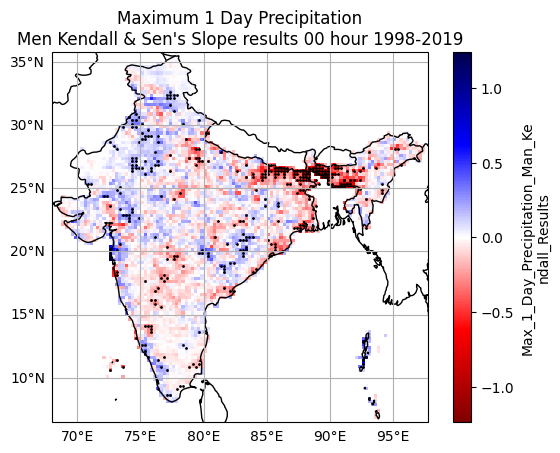

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

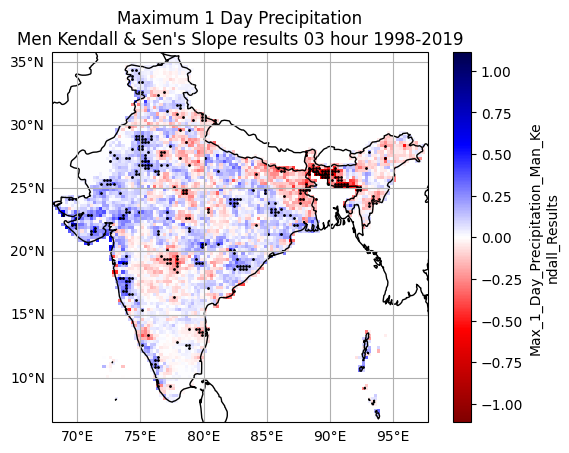

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

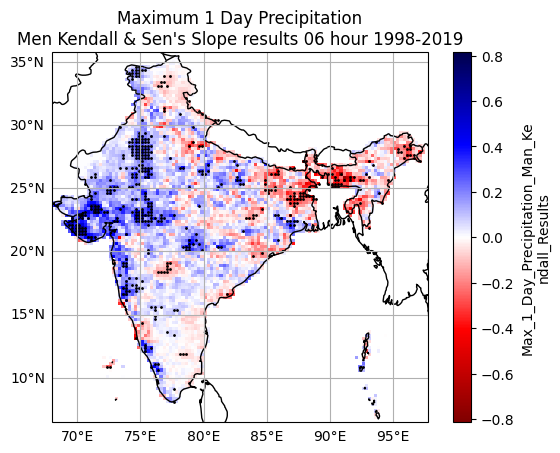

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

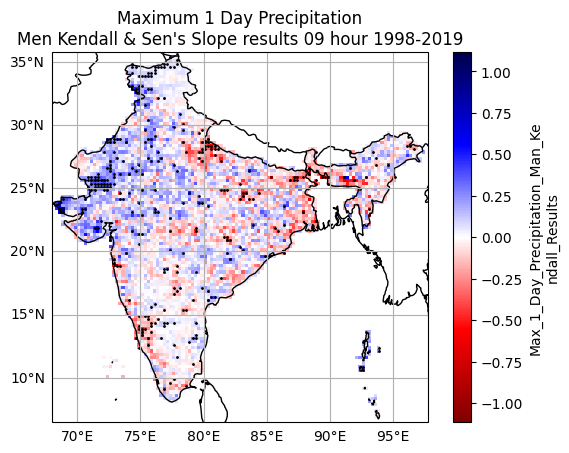

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

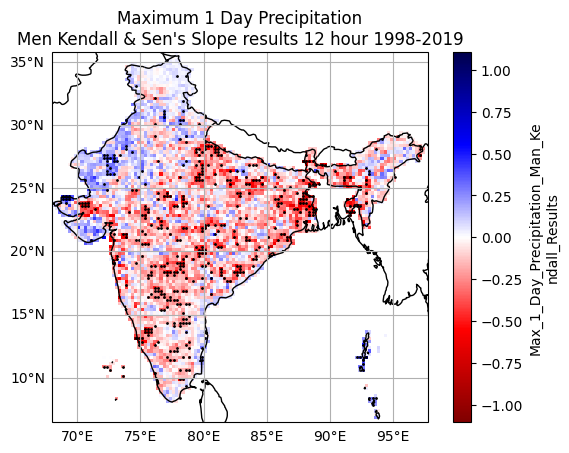

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

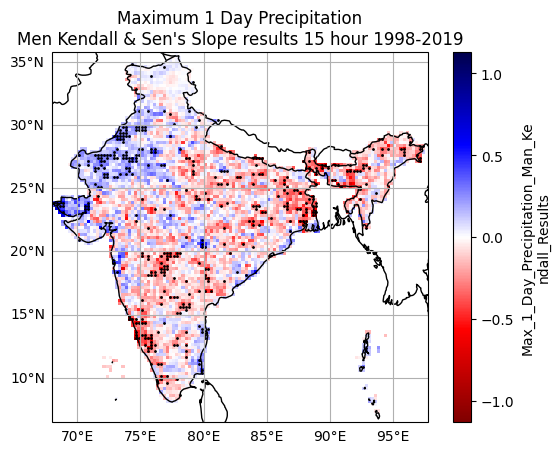

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

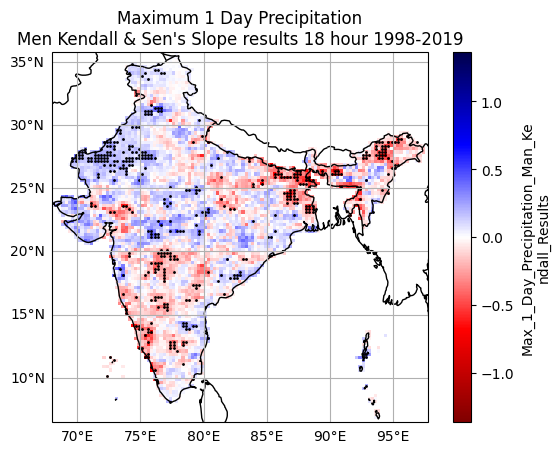

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

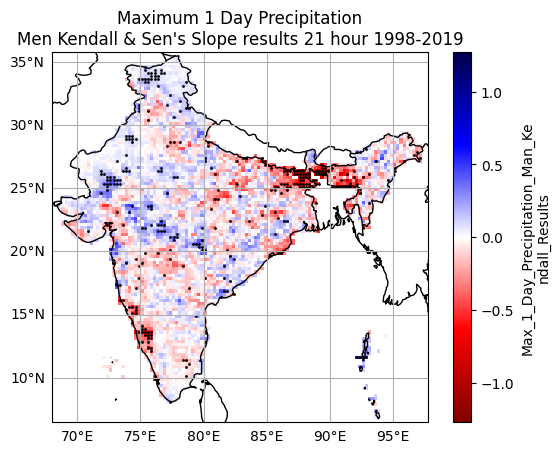

In [54]:
hours = ["00","03","06","09","12","15","18","21"]
directory="RX_1day"
for hour in hours:
    max_1_day_prec = LoadData(hour,directory)
    plot_data,lons,lats = ManKendallTest(max_1_day_prec,directory)
    plot_data,intercept_plot,count = SenSlope(max_1_day_prec,directory)
    PlotCombinedGraph(plot_data,lons,lats,directory,hour=hour)

## Index : MAX-5 Day Precipitation

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Lib

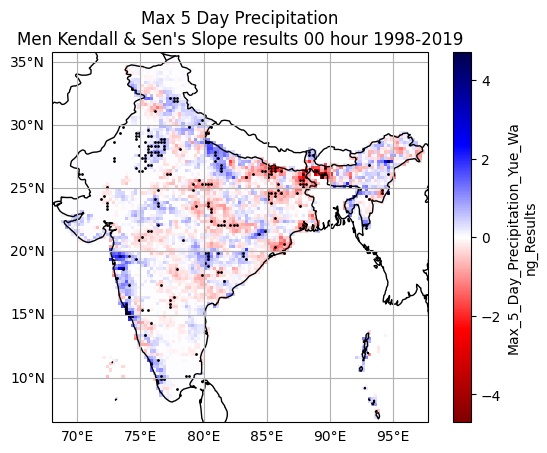

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Lib

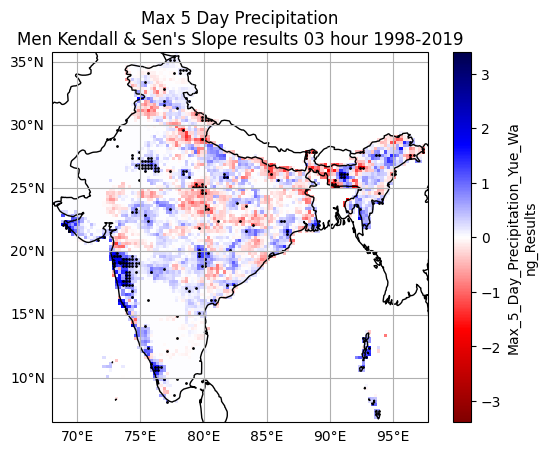

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Lib

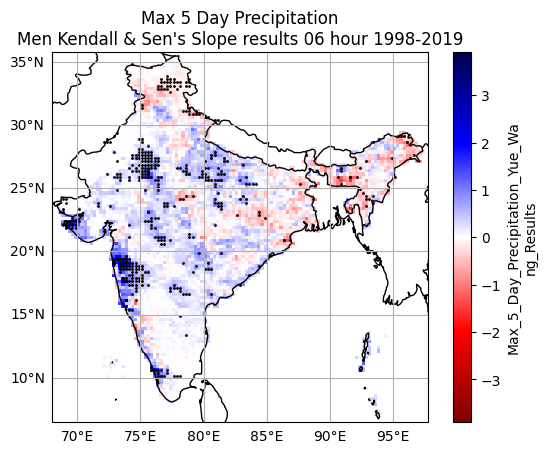

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Lib

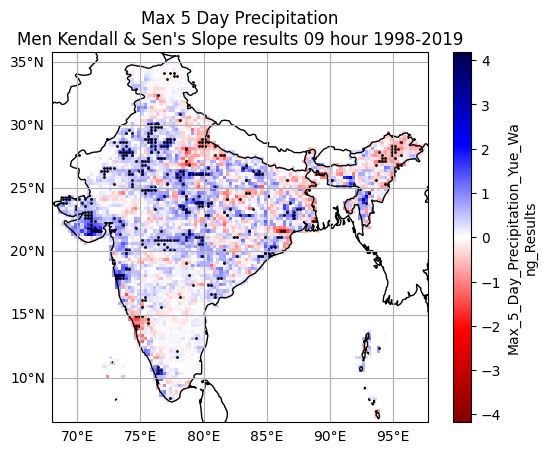

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Lib

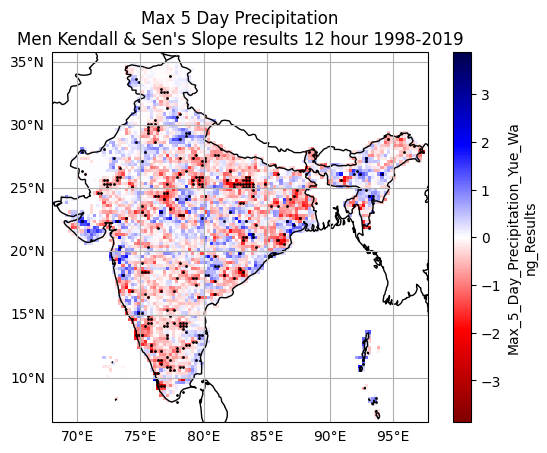

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Lib

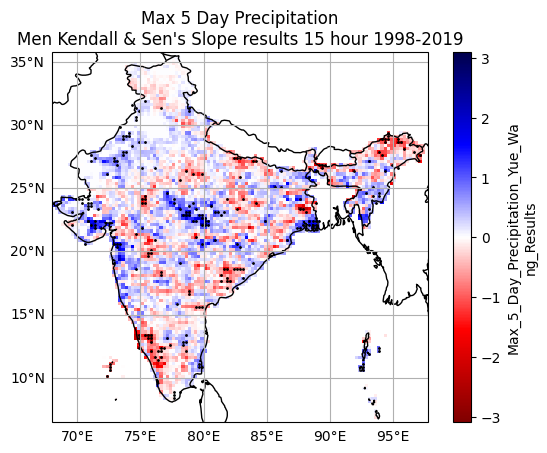

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Lib

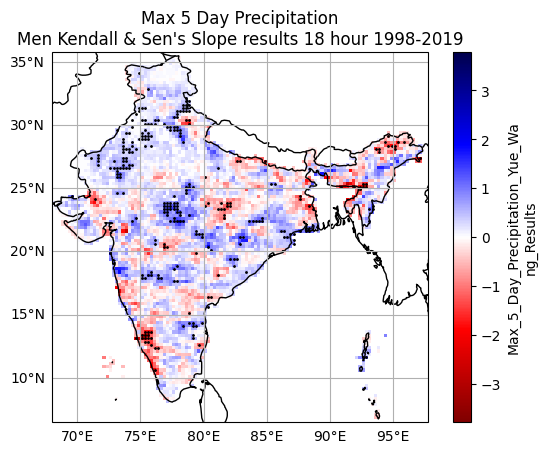

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Lib

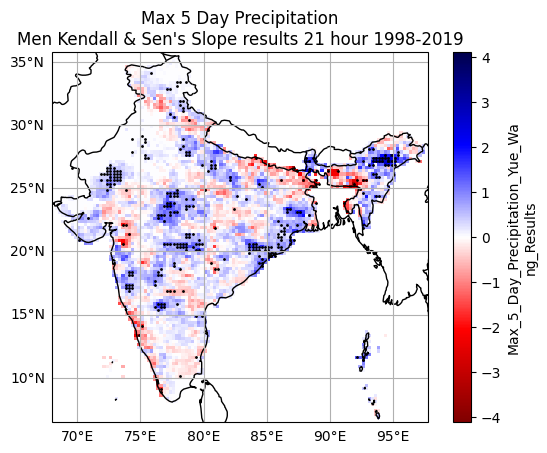

In [58]:
hours = ["00","03","06","09","12","15","18","21"]
directory="RX_5day"
for hour in hours:
    max_1_day_prec = LoadData(hour,directory)
    plot_data,lons,lats = ManKendallTest(max_1_day_prec,directory)
    plot_data,intercept_plot,count = SenSlope(max_1_day_prec,directory)
    PlotCombinedGraph(plot_data,lons,lats,directory,hour=hour,index="Max 5 Day Precipitation")

## Index : Heavy Precipitation

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

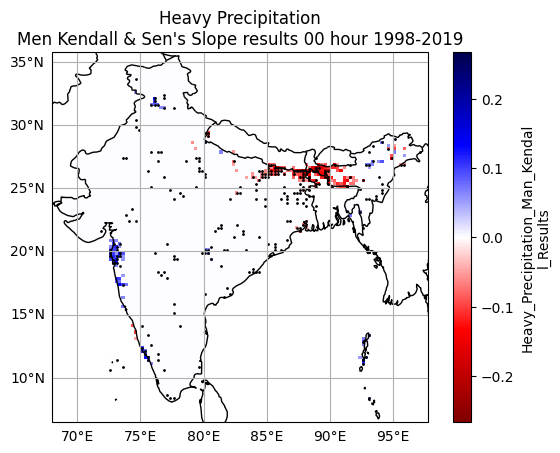

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

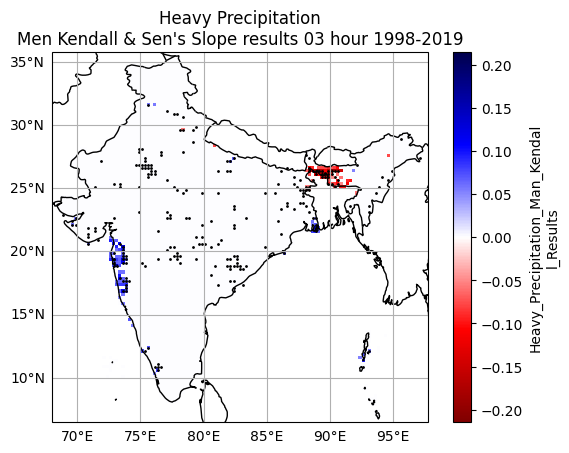

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

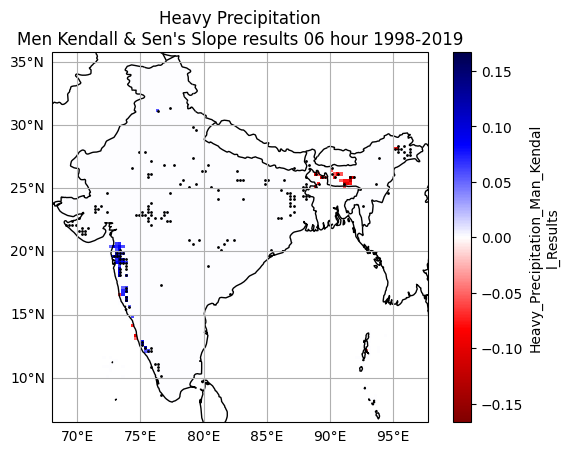

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

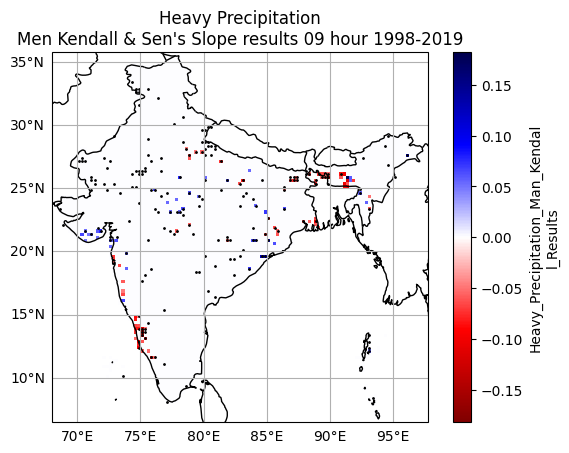

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

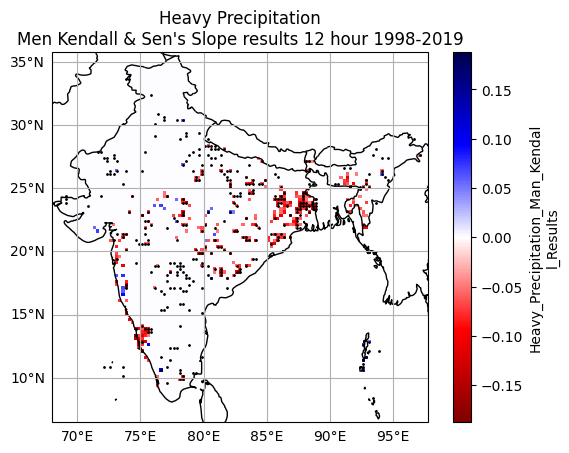

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

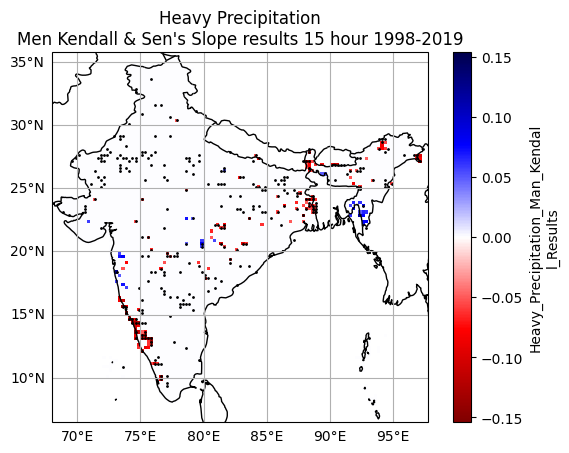

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

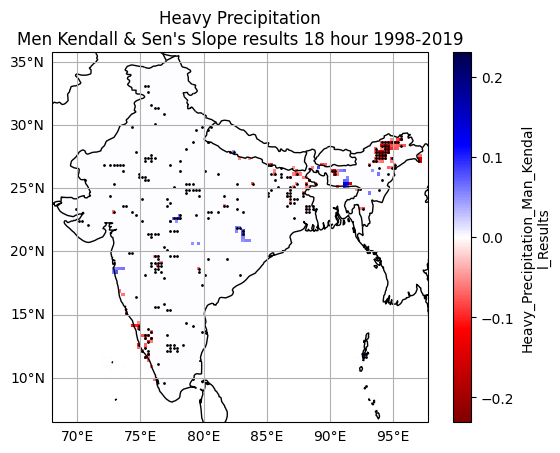

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

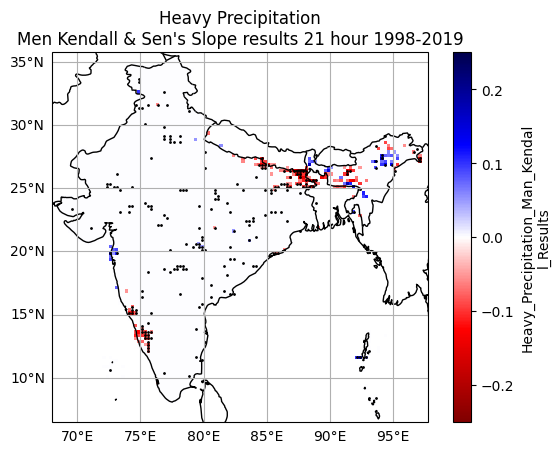

In [61]:
hours = ["00","03","06","09","12","15","18","21"]
directory="ECA_r10MM_HEAVY_PRECIPITATION"
for hour in hours:
    max_1_day_prec = LoadData(hour,directory)
    plot_data,lons,lats = ManKendallTest(max_1_day_prec,directory)
    plot_data,intercept_plot,count = SenSlope(max_1_day_prec,directory)
    PlotCombinedGraph(plot_data,lons,lats,directory,hour=hour,index="Heavy Precipitation")

## Index : Very Wet Days

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

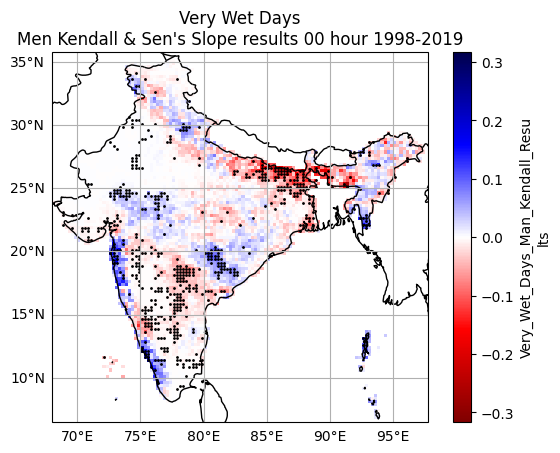

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

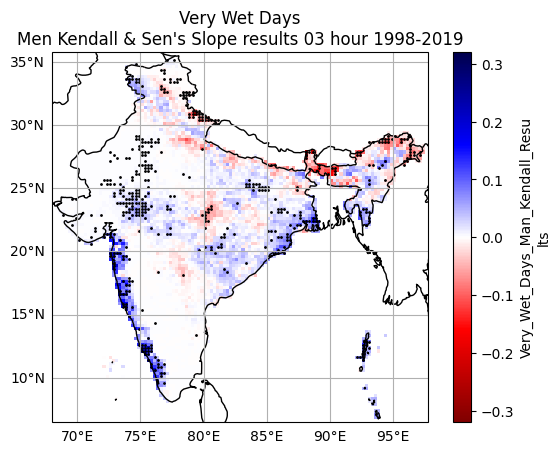

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

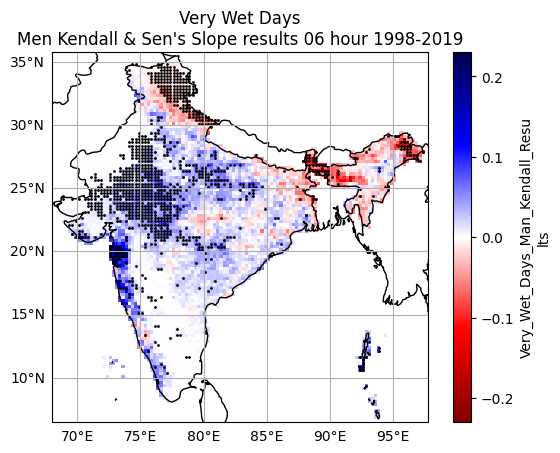

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

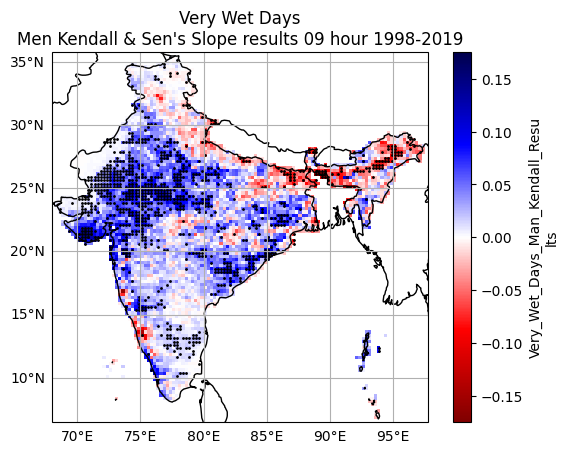

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

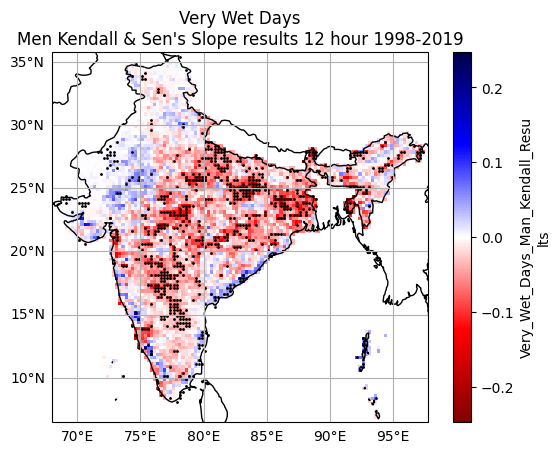

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

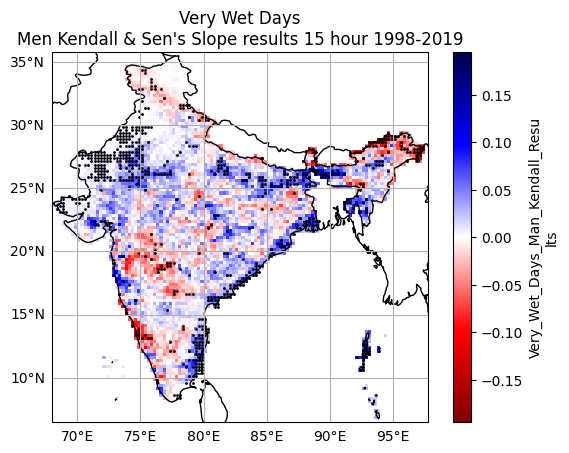

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

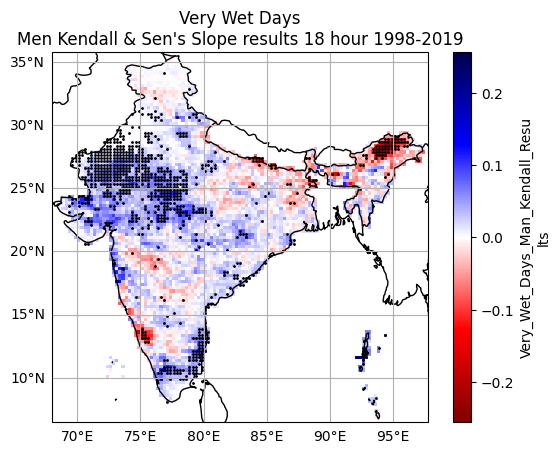

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

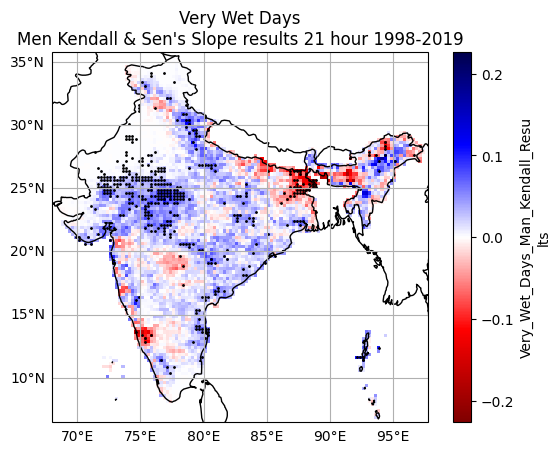

In [65]:
hours = ["00","03","06","09","12","15","18","21"]
directory="Very_Wet_Precipitation"
for hour in hours:
    max_1_day_prec = LoadData(hour,directory)
    plot_data,lons,lats = ManKendallTest(max_1_day_prec,directory)
    plot_data,intercept_plot,count = SenSlope(max_1_day_prec,directory)
    PlotCombinedGraph(plot_data,lons,lats,directory,hour=hour,index="Very Wet Days")

## Index : Extremely Wet Days

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

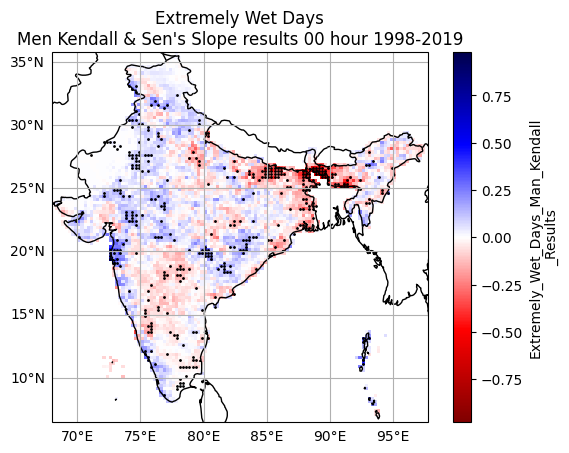

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

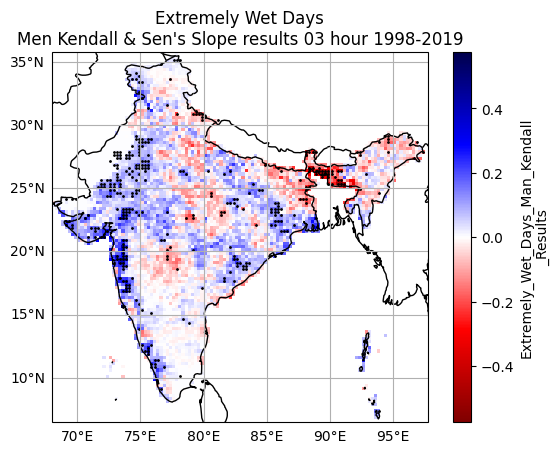

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

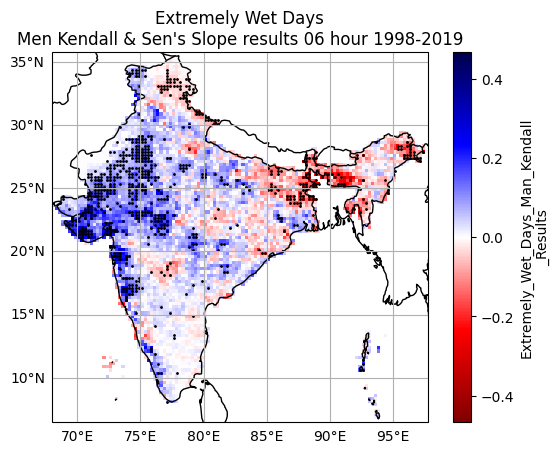

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

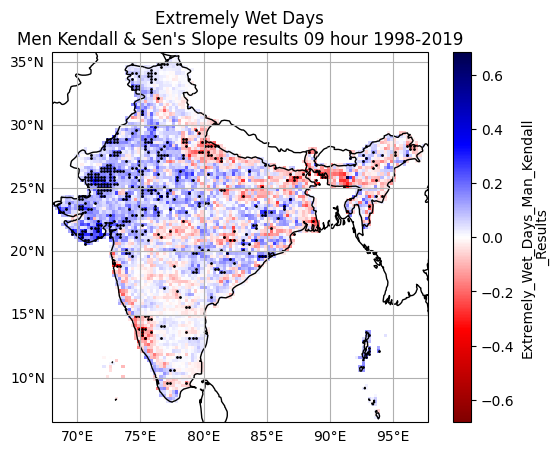

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

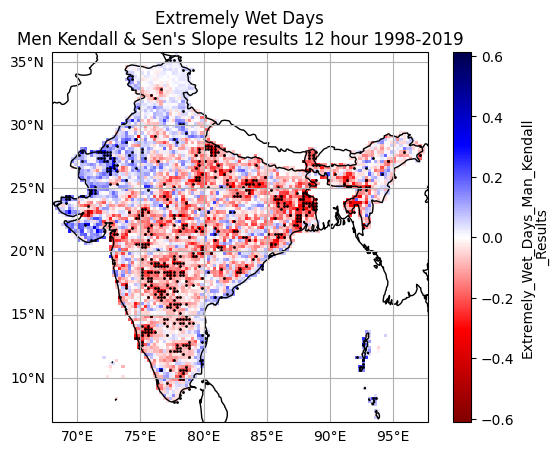

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

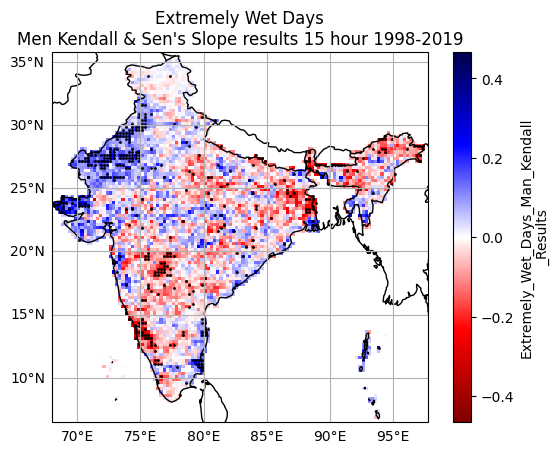

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

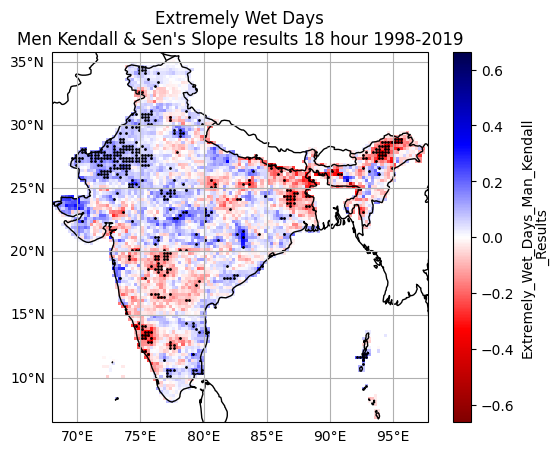

/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:180: RuntimeWarning: All-NaN slice encountered
  slope = np.nanmedian(__sens_estimator(x))
/Users/yuvrajsinhdilipsinhbodana/Library/Python/3.11/lib/python/site-packages/pymannkendall/pymannkendall.py:181: RuntimeWarning: All-NaN slice encountered
  intercept = np.nanmedian(x) - np.median(np.arange(n)[~np.isnan(x.flatten())]) * slope  # or median(x) - (n-1)/2 *slope
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarni

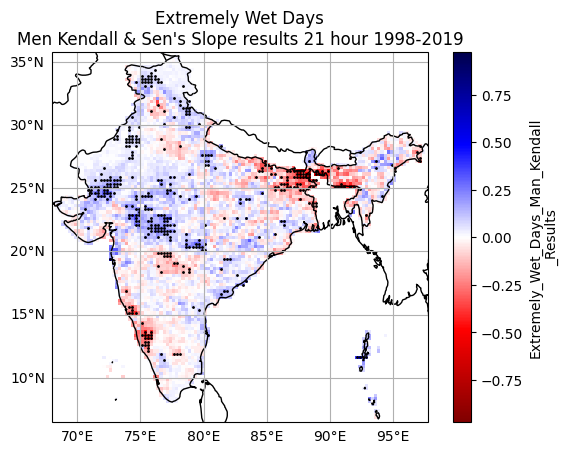

In [66]:
hours = ["00","03","06","09","12","15","18","21"]
directory="Extremely_Wet_Precipitation"
for hour in hours:
    max_1_day_prec = LoadData(hour,directory)
    plot_data,lons,lats = ManKendallTest(max_1_day_prec,directory)
    plot_data,intercept_plot,count = SenSlope(max_1_day_prec,directory)
    PlotCombinedGraph(plot_data,lons,lats,directory,hour=hour,index="Extremely Wet Days")

## Index : Consecutive Dry Days

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


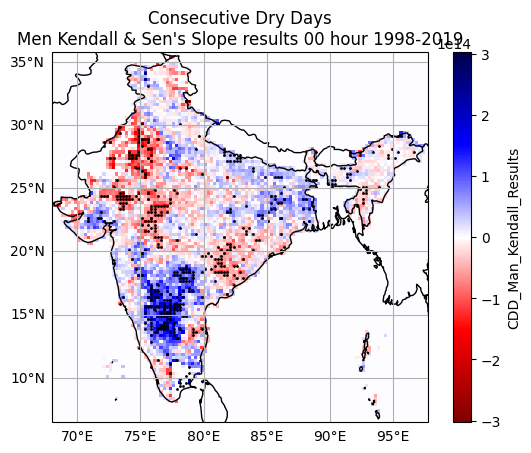

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


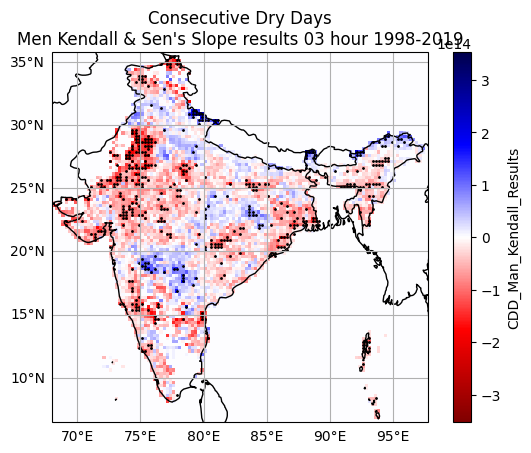

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


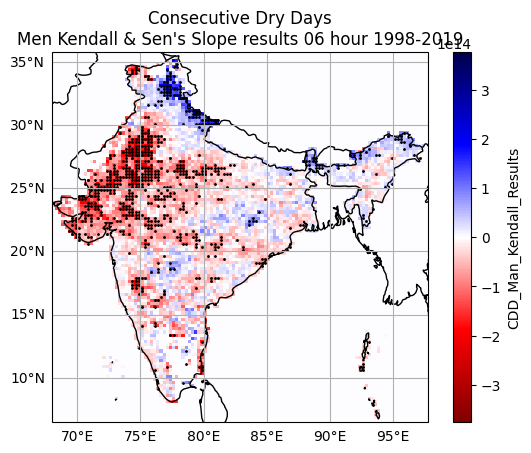

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


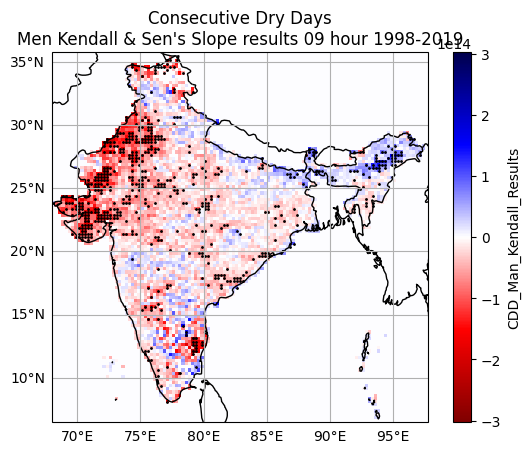

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


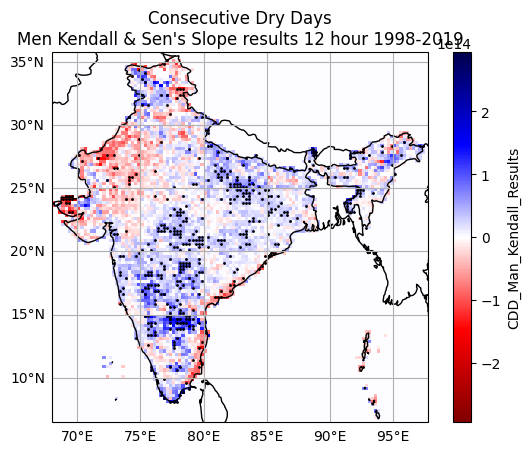

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


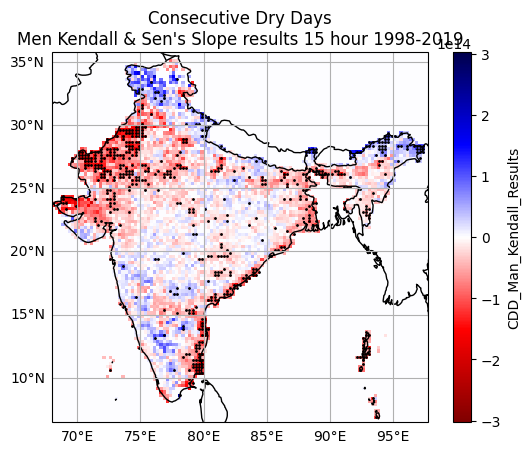

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


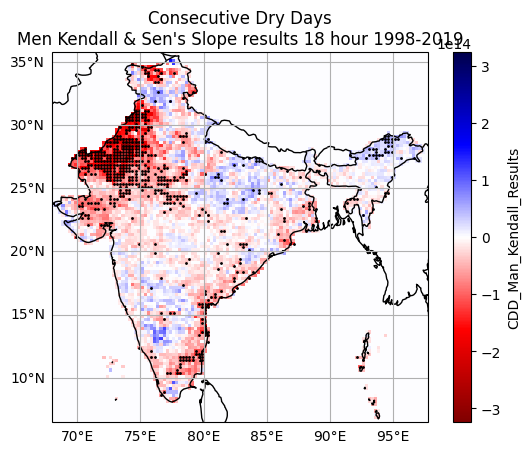

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


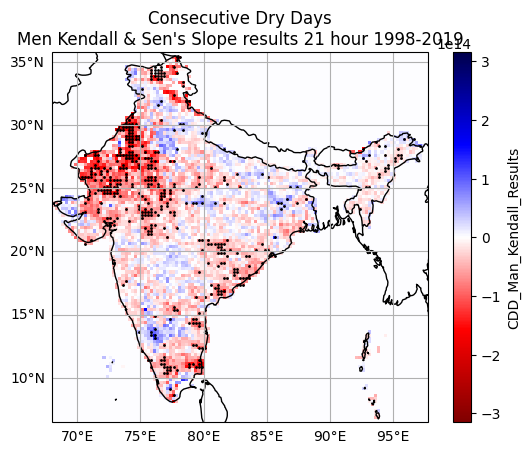

In [67]:
hours = ["00","03","06","09","12","15","18","21"]
directory="CDD_Consecutive_Dry_Days"
for hour in hours:
    max_1_day_prec = LoadData(hour,directory)
    plot_data,lons,lats = ManKendallTest(max_1_day_prec,directory)
    plot_data,intercept_plot,count = SenSlope(max_1_day_prec,directory)
    PlotCombinedGraph(plot_data,lons,lats,directory,hour=hour,index="Consecutive Dry Days")

## Index : Consecutive Wet Days

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


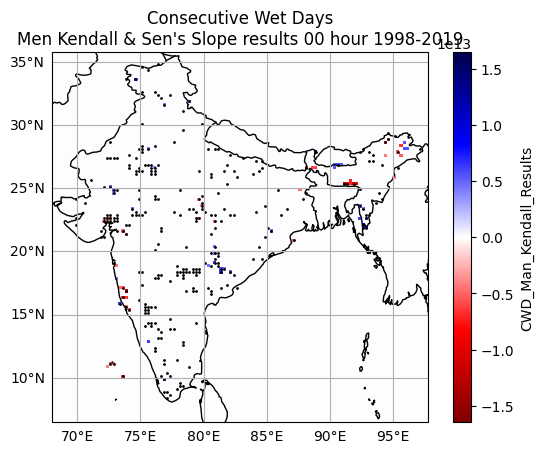

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


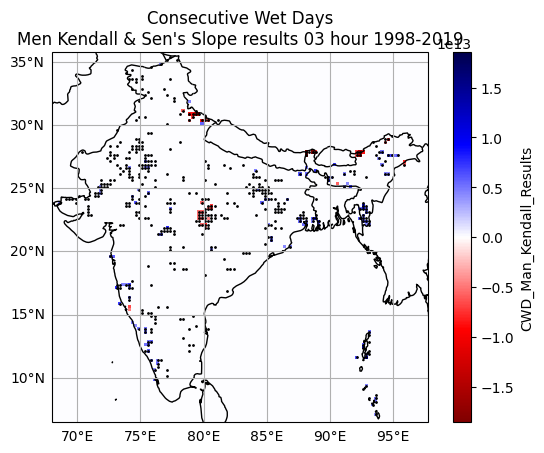

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


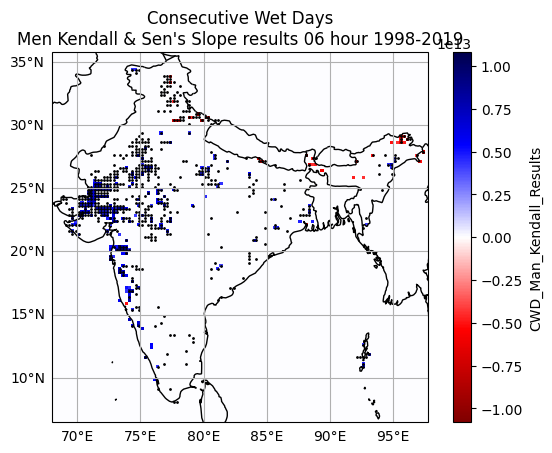

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


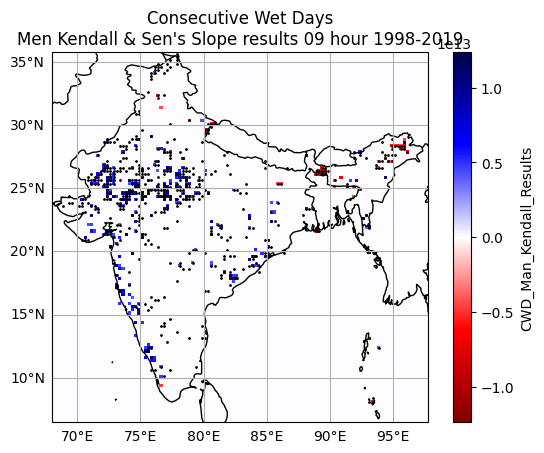

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


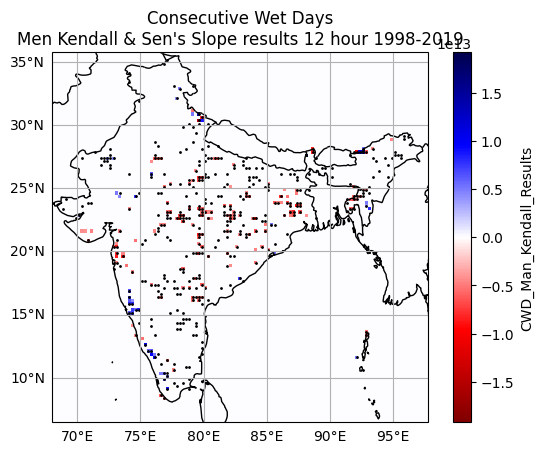

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


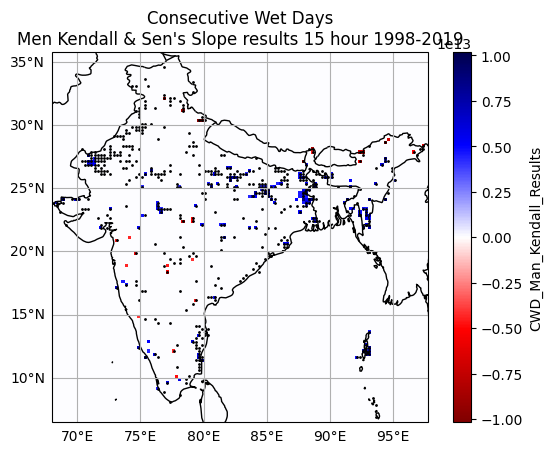

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


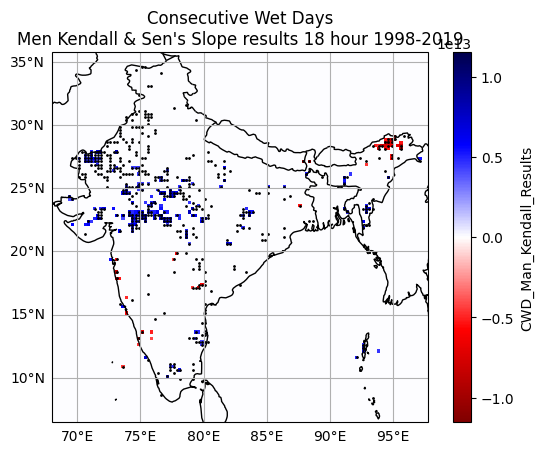

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


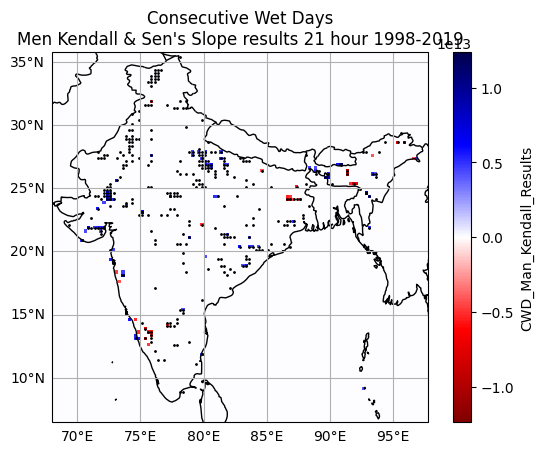

In [68]:
hours = ["00","03","06","09","12","15","18","21"]
directory="CWD_Consecutive_Wet_Days"
for hour in hours:
    max_1_day_prec = LoadData(hour,directory)
    plot_data,lons,lats = ManKendallTest(max_1_day_prec,directory)
    plot_data,intercept_plot,count = SenSlope(max_1_day_prec,directory)
    PlotCombinedGraph(plot_data,lons,lats,directory,hour=hour,index="Consecutive Wet Days")